##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [6]:
%pip uninstall -qqy jupyterlab
%pip install -U -q "google-genai==1.7.0"
%pip install -U -q ipython-sql

Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from google import genai
from google.genai import types

genai.__version__

'1.7.0'

In [2]:
import os

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")

In [3]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
    genai.models.Models.generate_content = retry.Retry(predicate=is_retriable)(genai.models.Models.generate_content)

In [4]:
%load_ext sql
%sql sqlite:///sample.db

In [5]:
%%sql
DROP TABLE IF EXISTS products;
-- Create the 'products' table
CREATE TABLE IF NOT EXISTS products (
  	product_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	product_name VARCHAR(255) NOT NULL,
  	price DECIMAL(10, 2) NOT NULL
  );

DROP TABLE IF EXISTS staff;
-- Create the 'staff' table
CREATE TABLE IF NOT EXISTS staff (
  	staff_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	first_name VARCHAR(255) NOT NULL,
  	last_name VARCHAR(255) NOT NULL
  );

DROP TABLE IF EXISTS orders;
-- Create the 'orders' table
CREATE TABLE IF NOT EXISTS orders (
  	order_id INTEGER PRIMARY KEY AUTOINCREMENT,
  	customer_name VARCHAR(255) NOT NULL,
  	staff_id INTEGER NOT NULL,
  	product_id INTEGER NOT NULL,
  	FOREIGN KEY (staff_id) REFERENCES staff (staff_id),
  	FOREIGN KEY (product_id) REFERENCES products (product_id)
  );

-- Insert data into the 'products' table
INSERT INTO products (product_name, price) VALUES
  	('Laptop', 799.99),
  	('Keyboard', 129.99),
  	('Mouse', 29.99);

-- Insert data into the 'staff' table
INSERT INTO staff (first_name, last_name) VALUES
  	('Alice', 'Smith'),
  	('Bob', 'Johnson'),
  	('Charlie', 'Williams');

-- Insert data into the 'orders' table
INSERT INTO orders (customer_name, staff_id, product_id) VALUES
  	('David Lee', 1, 1),
  	('Emily Chen', 2, 2),
  	('Frank Brown', 1, 3);

 * sqlite:///sample.db
Done.
Done.
Done.
Done.
Done.
Done.
3 rows affected.
3 rows affected.
3 rows affected.


[]

In [6]:
import sqlite3

db_file = "sample.db"
db_conn = sqlite3.connect(db_file)

In [7]:
def list_tables() -> list[str]:
    """Retrieve the names of all talbes in the database."""
    print(' - DB CALL: list_tables()')

    cursor = db_conn.cursor()

    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    return [t[0] for t in tables]

list_tables()

 - DB CALL: list_tables()


['sqlite_sequence', 'products', 'staff', 'orders']

In [8]:
def describe_table(table_name: str) -> list[tuple[str, str]]:
    """Look up the table schema.
    
    Returns:
      List of columns, where each entry is a tuple of (column, type).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = db_conn.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()

    return [(col[1], col[2]) for col in schema]

describe_table("products")


 - DB CALL: describe_table(products)


[('product_id', 'INTEGER'),
 ('product_name', 'VARCHAR(255)'),
 ('price', 'DECIMAL(10, 2)')]

In [9]:
def execute_query(sql: str) -> list[list[str]]:
    """Execute an SQL statement, returning the results."""
    print(f' - DB CALL: execute_query({sql})')
    
    cursor = db_conn.cursor()
    
    cursor.execute(sql)
    return cursor.fetchall()

execute_query("select * from products")

 - DB CALL: execute_query(select * from products)


[(1, 'Laptop', 799.99), (2, 'Keyboard', 129.99), (3, 'Mouse', 29.99)]

## Function calls 구현
이제 Gemini API 호출 하나로 모든 것을 통합할 수 있습니다.

함수 호출은 채팅 세션에 특정 메시지를 추가하는 방식으로 작동합니다. 함수 스키마가 정의되어 모델에 제공되고 대화가 시작되면 모델은 텍스트 응답 대신 `function_call`을 반환할 수 있습니다. 이 경우 클라이언트는 호출 결과를 나타내는 `function_response`로 응답해야 하며, 대화는 정상적으로 계속 진행될 수 있습니다.

이 함수 호출 상호작용은 일반적으로 수동으로 이루어지므로 클라이언트는 호출의 유효성을 검사하고 시작할 수 있습니다. 하지만 Python SDK는 제공된 함수가 자동으로 호출되는 **자동 함수 호출**도 지원합니다. 이는 강력한 기능이지만, 함수에 부작용이 없는 경우처럼 주의해서 사용해야 합니다.

다음은 함수 호출을 사용한 대화 흐름을 나타내는 상태 다이어그램입니다. 자동 함수 호출을 사용하면 Python SDK가 맨 아래 행을 자동으로 실행합니다. 수동 함수 호출을 사용하면 각 단계를 개별적으로 실행하는 코드를 작성해야 합니다.

![function calling state diagram](https://codelabs.developers.google.com/static/codelabs/gemini-function-calling/img/gemini-function-calling-overview_1440.png)

In [100]:
db_tools = [list_tables, describe_table, execute_query]

instruction = """당신은 컴퓨터 매장의 SQL 데이터베이스와 상호 작용할 수 있는 유용한 챗봇입니다.
사용자의 질문을 받아 사용 가능한 도구를 사용하여 SQL 쿼리로 변환합니다.
필요한 정보를 확보하면 반환된 데이터를 사용하여 사용자의 질문에 답변합니다.

list_tables 를 사용하여 현재 데이터베이스에 있는 테이블을 확인하고, describe_table 을 사용하여 테이블 스키마를 파악하고, execute_query 를 사용하여 SQL SELECT 쿼리를 실행합니다."""

# instruction = """You are a helpful chatbot that can interact with an SQL database
# for a computer store. You will take the users questions and turn them into SQL
# queries using the tools available. Once you have the information you need, you will
# answer the user's question using the data returned.

# Use list_tables to see what tables are present, describe_table to understand the
# schema, and execute_query to issue an SQL SELECT query."""


In [90]:
client = genai.Client(api_key=GOOGLE_API_KEY)

chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,
    )
)

In [86]:
response = chat.send_message("What is the cheapest product?")
print(f"\n{response.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(products)
 - DB CALL: execute_query(SELECT product_name, price FROM products ORDER BY price ASC LIMIT 1)

The cheapest product is the Mouse, which costs $29.99.


In [91]:
response = chat.send_message("가장 저렴한 제품(product)은 무엇입니까?")
print(f"\n{response.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(products)
 - DB CALL: execute_query(SELECT product_name, price FROM products ORDER BY price ASC LIMIT 1)

가장 저렴한 제품은 29.99달러짜리 마우스입니다.


In [101]:
client = genai.Client(api_key=GOOGLE_API_KEY)

chat = client.chats.create(
    model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
        system_instruction=instruction,
        tools=db_tools,        
    )
)

In [102]:
response = chat.send_message("영업사원 앨리스(Alice)는 포트폴리오를 완성(round out her portfolio)하기 위해 어떤 제품에 집중해야 할까요? 그 이유를 설명하세요.")
print(f"\n{response.text}")

 - DB CALL: list_tables()
 - DB CALL: describe_table(staff)
 - DB CALL: describe_table(products)
 - DB CALL: describe_table(orders)
 - DB CALL: execute_query(SELECT staff_id FROM staff WHERE first_name = 'Alice')
 - DB CALL: execute_query(SELECT product_id FROM orders WHERE staff_id = 1)
 - DB CALL: execute_query(SELECT product_id FROM products)
 - DB CALL: execute_query(SELECT product_name FROM products WHERE product_id = 2)

앨리스는 포트폴리오를 완성하기 위해 키보드 판매에 집중해야 합니다. 그녀는 컴퓨터와 마우스를 판매했지만 키보드는 판매하지 않았기 때문입니다.



In [81]:
response = chat.send_message("What products should salesperson Alice focus on to round out her portfolio? Explain why.")
print(f"\n{response.text}")


Alice should focus on selling Keyboards. Other salespersons have sold keyboards, while Alice has only sold Laptops and Mouse.



In [103]:
import textwrap

def print_chat_turns(chat):
    """Print out each turn in the chat history, including functio calls and responses."""
    for event in chat.get_history():
        print(f"{event.role.capitalize()}:")

        for part in event.parts:
            if txt := part.text:
                print(f'  "{txt}')
            elif fn := part.function_call:
                args = ", ".join(f"{key}={val}" for key, val in fn.args.items())
                print(f"  Function call: {fn.name}({args})")
            elif resp := part.function_response:
                print("  Function response:")
                print(textwrap.indent(str(resp.response['result']), "    "))
        print()



In [104]:
print_chat_turns(chat)

User:
  "영업사원 앨리스(Alice)는 포트폴리오를 완성(round out her portfolio)하기 위해 어떤 제품에 집중해야 할까요? 그 이유를 설명하세요.

Model:
  "앨리스가 집중해야 할 제품을 알려면 먼저 앨리스가 판매한 제품을 알아야 합니다. 그리고 '영업사원'이라는 용어가 사용된 테이블과 '제품' 정보가 들어 있는 테이블을 알아야 합니다. 먼저 테이블을 나열해 보겠습니다.

  Function call: list_tables()

User:
  Function response:
    ['sqlite_sequence', 'products', 'staff', 'orders']

Model:
  "'staff', 'products', 'orders' 테이블이 있습니다. 'staff' 테이블에 영업사원 정보가 있을 가능성이 높고 'products' 테이블에 제품 정보가 있을 가능성이 높습니다. 'orders' 테이블에는 주문이 들어 있을 가능성이 높습니다. 'staff' 테이블과 'products' 테이블의 스키마를 확인해 보겠습니다.

  Function call: describe_table(table_name=staff)
  Function call: describe_table(table_name=products)

User:
  Function response:
    [('staff_id', 'INTEGER'), ('first_name', 'VARCHAR(255)'), ('last_name', 'VARCHAR(255)')]
  Function response:
    [('product_id', 'INTEGER'), ('product_name', 'VARCHAR(255)'), ('price', 'DECIMAL(10, 2)')]

Model:
  "'staff' 테이블에는 'staff_id', 'first_name', 'last_name' 열이 있습니다. 'products' 테이블에는 'product_id', 'product_na

## Compositional function calling

Gemini 2.0의 강력한 새 기능 중 하나는 코드를 생성하는 동안 사용자가 제공한 함수 호출을 함께 구성할 수 있는 기능입니다.

즉, 모델은 사용 가능한 도구를 사용하여 해당 도구를 사용하는 코드를 생성하고 이를 모두 실행할 수 있습니다.

이 기능에는 Live API가 필요하므로 이 단계에서는 지금까지 살펴본 대부분의 예제와는 다른 설정 코드를 사용합니다. Multimodal Live API는 양방향 스트리밍 서비스이므로 모든 것이 미리 설정된 후 실행됩니다. 이는 조금 더 복잡하지만 그 결과는 매우 강력합니다.

먼저 스트리밍 모델 출력을 처리하는 함수를 정의합니다. 이 함수는 텍스트 출력을 스트리밍하고, 도구 호출을 처리하고, 모델이 작업을 수행하기 위해 작성하고 실행하는 생성된 코드를 보여줍니다.

In [10]:
from pprint import pformat
from IPython.display import display, Image, Markdown

async def handle_response(stream, tool_impl=None):
    """Stream out and handle any tool calls during the session"""
    all_responses = []

    async for msg in stream.receive():
        all_responses.append(msg)

        if text := msg.text:
            # Output any text chunks that are streamed back.
            if len(all_responses) < 2 or not all_responses[-2].text:
                # Display a header if this is the first text chunk.
                display(Markdown('### Text'))
            
            print(text, end='')
        
        elif tool_call := msg.tool_call:
            # Handle tool-call requests.
            for fc in tool_call.function_calls:
                display(Markdown('### Tool call'))

                # Execute the tool and collect the result to return to the model.
                if callable(tool_impl):
                    try:
                        result = tool_impl(**fc.args)
                    except Exception as e:
                        result = str(e)
                else:
                    result = 'ok'
                
                tool_response = types.LiveClientToolResponse(
                    function_responses=[types.FunctionResponse(
                        name=fc.name,
                        id=fc.id,
                        response={'result': result},
                    )]
                )
                await stream.send(input=tool_response)

        elif msg.server_content and msg.server_content.model_turn:
            # Print andy messages showing code the model generated and run.

            for part in msg.server_content.model_turn.parts:
                if code := part.executable_code:
                    display(Markdown(
                        f'### Code\n```\n{code.code}\n```'
                    ))
                elif result := part.code_execution_result:
                    display(Markdown(
                        f'### Result: {result.outcome}\n'
                        f'```\n{pformat(result.output)}\n```'
                    ))
                elif img := part.inline_data:
                    display(Image(img.data))

    print()
    return all_responses

### Textual live database chat
이제 모델에 연결하여 대화를 시작하세요.

Live API는 스트리밍 API이므로 이 예제는 완전히 사전 스크립트화되어 있으며 사용자 입력은 단 하나뿐입니다. 그럼에도 불구하고, 요청은 모델이 데이터베이스를 조회하기 위해 약간의 왕복 작업을 수행해야 하며, 모델이 반복문에서 execute_query 도구를 사용하는 코드를 생성하는 것을 볼 수 있습니다.

In [11]:
model = 'gemini-2.0-flash-exp'
live_client = genai.Client(api_key=GOOGLE_API_KEY,
                           http_options=types.HttpOptions(api_version='v1alpha'))

# Wrap the existing execute_query tool you used in the earlier example.
execute_query_tool_def = types.FunctionDeclaration.from_callable(
    client=live_client, callable=execute_query
)

# Provide the model with enough information to use the tool, such as describing 
# the database so it understnads which SQL syntax to use.
sys_int = """당신은 데이터베이스 인터페이스입니다. `execute_query` 함수를 사용하여
데이터베이스에서 테이블 스키마 같은 직접 정보를 조회하고,
필요한 쿼리를 실행하고, 사용자에게 응답하여 사용자의 질문에 답변하세요.

sqlite3 구문 SQL을 사용하여 테이블 스키마를 조회한 후,
답변을 찾으면 사용자에게 알려야 합니다. 사용자가 작업을 요청하는 경우,
작업을 실행해야 합니다.
"""

# sys_int = """You are a database interface. Use the `execute_query` function
# to answer the users questions by looking up information like schema in the database,
# running any necessary queries and responding to the user.

# You need to look up table schema using sqlite3 syntax SQL, then once an
# answer is found be sure to tell the user. If the user is requesting an
# action, you must also execute the actions.
# """

config = {
    "response_modalities": ["TEXT"],
    "system_instruction": {"parts": [{"text": sys_int}]},
    "tools": [
        {"code_execution": {}},
        {"function_declarations": [execute_query_tool_def.to_json_dict()]},
    ],
}

In [12]:
async def chat(stream, message):
    await stream.send(input=message, end_of_turn=True)
    await handle_response(stream, tool_impl=execute_query)    

In [13]:
async with live_client.aio.live.connect(model=model, config=config) as session:
    # message = "Please generate and insert 5 new rows in the orders table."
    message = "order 테이블에 5개의 임의의 새로운 행을 생성하여 삽입하세요."
    print(f"> {message}\n")

    await chat(session, message)

/var/folders/sk/72429_w95sz049jdbs5_8p3n68w8h9/T/ipykernel_38382/1523470999.py:1: ExperimentalWarning: The live API is experimental and may change in future versions.
  async with live_client.aio.live.connect(model=model, config=config) as session:


> order 테이블에 5개의 임의의 새로운 행을 생성하여 삽입하세요.



### Text

삽입해야 하는 테이블의 스키마를 알아야 합니다. SQL 구문을 사용하여 order 테이블의 스키마를 얻어오겠습니다.

### Code
```
sql = "PRAGMA table_info(orders)"
print(sql)

```

### Result: Outcome.OUTCOME_OK
```
'PRAGMA table_info(orders)\n'
```

### Text

이제 테이블의 스키마를 얻어왔습니다. 이제 5개의 임의의 새 행을 생성하여 삽입해 보겠습니다. 적절한 값을 제공해야 하므로, `execute_query`를 실행한 후에 생성된 스키마를 검토해야 합니다.

### Code
```
sql = "PRAGMA table_info(orders)"
result = default_api.execute_query(sql=sql)
print(result)

```

### Tool call

 - DB CALL: execute_query(PRAGMA table_info(orders))


### Result: Outcome.OUTCOME_OK
```
("{'result': [[0, 'order_id', 'INTEGER', 0, None, 1], [1, 'customer_name', "
 "'VARCHAR(255)', 1, None, 0], [2, 'staff_id', 'INTEGER', 1, None, 0], [3, "
 "'product_id', 'INTEGER', 1, None, 0]]}\n")
```

### Text

좋습니다. 이제 orders 테이블의 스키마를 알고 있습니다. 테이블은 다음과 같습니다.
order_id INTEGER PRIMARY KEY,
customer_name VARCHAR(255) NOT NULL,
staff_id INTEGER NOT NULL,
product_id INTEGER NOT NULL

이제 5개의 임의의 새 행을 삽입하는 SQL 쿼리를 만들 수 있습니다.
직원 ID 및 제품 ID가 존재하는지, 그리고 테이블에 있는지 확인하지는 않습니다.



### Code
```
sql = """
INSERT INTO orders (customer_name, staff_id, product_id) VALUES
('John Smith', 1, 101),
('Alice Johnson', 2, 102),
('Bob Williams', 3, 103),
('Emily Brown', 4, 104),
('David Jones', 5, 105);
"""
print(sql)

```

### Result: Outcome.OUTCOME_OK
```
('\n'
 'INSERT INTO orders (customer_name, staff_id, product_id) VALUES\n'
 "('John Smith', 1, 101),\n"
 "('Alice Johnson', 2, 102),\n"
 "('Bob Williams', 3, 103),\n"
 "('Emily Brown', 4, 104),\n"
 "('David Jones', 5, 105);\n"
 '\n')
```

### Text

이제 이 쿼리를 실행해 보겠습니다.

### Code
```
sql = """
INSERT INTO orders (customer_name, staff_id, product_id) VALUES
('John Smith', 1, 101),
('Alice Johnson', 2, 102),
('Bob Williams', 3, 103),
('Emily Brown', 4, 104),
('David Jones', 5, 105);
"""
result = default_api.execute_query(sql=sql)
print(result)

```

### Tool call

 - DB CALL: execute_query(
INSERT INTO orders (customer_name, staff_id, product_id) VALUES
('John Smith', 1, 101),
('Alice Johnson', 2, 102),
('Bob Williams', 3, 103),
('Emily Brown', 4, 104),
('David Jones', 5, 105);
)


### Result: Outcome.OUTCOME_OK
```
"{'result': []}\n"
```

이전 단계의 출력에서 ​​모델이 작업을 완료하기 위해 생성한 코드를 보여주는 `코드` 섹션을 볼 수 있습니다. 코드는 다음과 같습니다.

```py
sql_statements = [ ... ]

for sql in sql_statements:
  print(default_api.execute_query(sql))
```

그런 다음 모델은 이 코드를 (원격으로) 실행하여 코드의 해당 부분에 도달하면 제공된 도구를 호출합니다. `default_api` 모듈에는 사용자가 제공한 도구가 포함되어 있습니다.

이 예제는 단순히 루프로 실행되지만, 모델은 여러 도구와 더욱 복잡한 상호작용을 수행할 수 있으므로 Gemini API에 효과적으로 내장된 강력한 에이전트 프레임워크를 제공합니다.

### Plotting the database

다음 예제에서 내장된 에이전트 기능을 사용해 보세요. 모델이 데이터베이스 스키마나 환경을 추측하려고 시도하는 것을 볼 수 있습니다. 모델은 종종 실수를 하지만, `Text` 출력을 살펴보면 모델이 오류를 검사하고, 새로운 접근 방식을 시도하며, 실수를 통해 학습하는 모습을 확인할 수 있습니다.

모델이 플롯을 반환하지 않으면 셀을 다시 실행해 보세요.

In [14]:
execute_query("select * from orders")

 - DB CALL: execute_query(select * from orders)


[(1, 'David Lee', 1, 1),
 (2, 'Emily Chen', 2, 2),
 (3, 'Frank Brown', 1, 3),
 (4, 'John Smith', 1, 101),
 (5, 'Alice Johnson', 2, 102),
 (6, 'Bob Williams', 3, 103),
 (7, 'Emily Brown', 4, 104),
 (8, 'David Jones', 5, 105)]

In [15]:
execute_query("""SELECT s.first_name, s.last_name, COUNT(o.order_id) AS total_orders
    FROM staff s
    LEFT JOIN orders o ON s.staff_id = o.staff_id
    GROUP BY s.staff_id, s.first_name, s.last_name;""")

 - DB CALL: execute_query(SELECT s.first_name, s.last_name, COUNT(o.order_id) AS total_orders
    FROM staff s
    LEFT JOIN orders o ON s.staff_id = o.staff_id
    GROUP BY s.staff_id, s.first_name, s.last_name;)


[('Alice', 'Smith', 3), ('Bob', 'Johnson', 2), ('Charlie', 'Williams', 1)]

### Text

네, 가능합니다. 먼저 데이터베이스 스키마를 조회하여 어떤 테이블이 있는지, 직원과 주문에 관한 정보가 어디에 있는지 알아야 합니다. 그런 다음 필요한 정보를 얻기 위한 쿼리를 작성할 수 있습니다.


### Code
```
import json
try:
    table_info_sql = "SELECT sql FROM sqlite_master WHERE type='table';"
    table_info_response = default_api.execute_query(sql=table_info_sql)
    print(json.dumps(table_info_response, indent=4))
except Exception as e:
    print(f"An error occurred: {e}")

```

### Tool call

 - DB CALL: execute_query(SELECT sql FROM sqlite_master WHERE type='table';)


### Result: Outcome.OUTCOME_OK
```
('{\n'
 '    "result": [\n'
 '        [\n'
 '            "CREATE TABLE sqlite_sequence(name,seq)"\n'
 '        ],\n'
 '        [\n'
 '            "CREATE TABLE products (\\n  \\tproduct_id INTEGER PRIMARY KEY '
 'AUTOINCREMENT,\\n  \\tproduct_name VARCHAR(255) NOT NULL,\\n  \\tprice '
 'DECIMAL(10, 2) NOT NULL\\n  )"\n'
 '        ],\n'
 '        [\n'
 '            "CREATE TABLE staff (\\n  \\tstaff_id INTEGER PRIMARY KEY '
 'AUTOINCREMENT,\\n  \\tfirst_name VARCHAR(255) NOT NULL,\\n  \\tlast_name '
 'VARCHAR(255) NOT NULL\\n  )"\n'
 '        ],\n'
 '        [\n'
 '            "CREATE TABLE orders (\\n  \\torder_id INTEGER PRIMARY KEY '
 'AUTOINCREMENT,\\n  \\tcustomer_name VARCHAR(255) NOT NULL,\\n  \\tstaff_id '
 'INTEGER NOT NULL,\\n  \\tproduct_id INTEGER NOT NULL,\\n  \\tFOREIGN KEY '
 '(staff_id) REFERENCES staff (staff_id),\\n  \\tFOREIGN KEY (product_id) '
 'REFERENCES products (product_id)\\n  )"\n'
 '        ]\n'
 '    ]\n'
 '}\n')
```

### Text

확인했습니다. 직원 테이블(`staff`)과 주문 테이블(`orders`)이 있습니다. 주문 테이블에는 `staff_id` 열이 있어 직원을 주문과 연결할 수 있습니다. 이제 각 직원이 주문한 수량을 알려주는 쿼리를 작성할 수 있습니다.


### Code
```
import json
try:
    query = """
    SELECT s.first_name, s.last_name, COUNT(o.order_id) AS total_orders
    FROM staff s
    LEFT JOIN orders o ON s.staff_id = o.staff_id
    GROUP BY s.staff_id, s.first_name, s.last_name;
    """
    response = default_api.execute_query(sql=query)
    print(json.dumps(response, indent=4))
except Exception as e:
    print(f"An error occurred: {e}")

```

### Tool call

 - DB CALL: execute_query(
    SELECT s.first_name, s.last_name, COUNT(o.order_id) AS total_orders
    FROM staff s
    LEFT JOIN orders o ON s.staff_id = o.staff_id
    GROUP BY s.staff_id, s.first_name, s.last_name;
    )


### Result: Outcome.OUTCOME_OK
```
('{\n'
 '    "result": [\n'
 '        [\n'
 '            "Alice",\n'
 '            "Smith",\n'
 '            3\n'
 '        ],\n'
 '        [\n'
 '            "Bob",\n'
 '            "Johnson",\n'
 '            2\n'
 '        ],\n'
 '        [\n'
 '            "Charlie",\n'
 '            "Williams",\n'
 '            1\n'
 '        ]\n'
 '    ]\n'
 '}\n')
```

### Text

결과가 나왔습니다. Alice Smith는 3개의 주문을, Bob Johnson은 2개의 주문을, Charlie Williams는 1개의 주문을 했습니다.


### Text

직원 이름을 사용하여 Python Seaborn 차트로 총 주문 수를 플로팅하기 위한 코드를 생성하고 실행합니다.


### Code
```
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

try:
    query = """
    SELECT s.first_name, s.last_name, COUNT(o.order_id) AS total_orders
    FROM staff s
    LEFT JOIN orders o ON s.staff_id = o.staff_id
    GROUP BY s.staff_id, s.first_name, s.last_name;
    """
    response = default_api.execute_query(sql=query)
    data = response["result"]
    df = pd.DataFrame(data, columns=['first_name', 'last_name', 'total_orders'])
    df['full_name'] = df['first_name'] + ' ' + df['last_name']

    plt.figure(figsize=(10, 6))
    sns.barplot(x='full_name', y='total_orders', data=df)
    plt.title('Total Orders per Staff Member')
    plt.xlabel('Staff Member')
    plt.ylabel('Total Orders')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")

```

### Tool call

 - DB CALL: execute_query(
    SELECT s.first_name, s.last_name, COUNT(o.order_id) AS total_orders
    FROM staff s
    LEFT JOIN orders o ON s.staff_id = o.staff_id
    GROUP BY s.staff_id, s.first_name, s.last_name;
    )


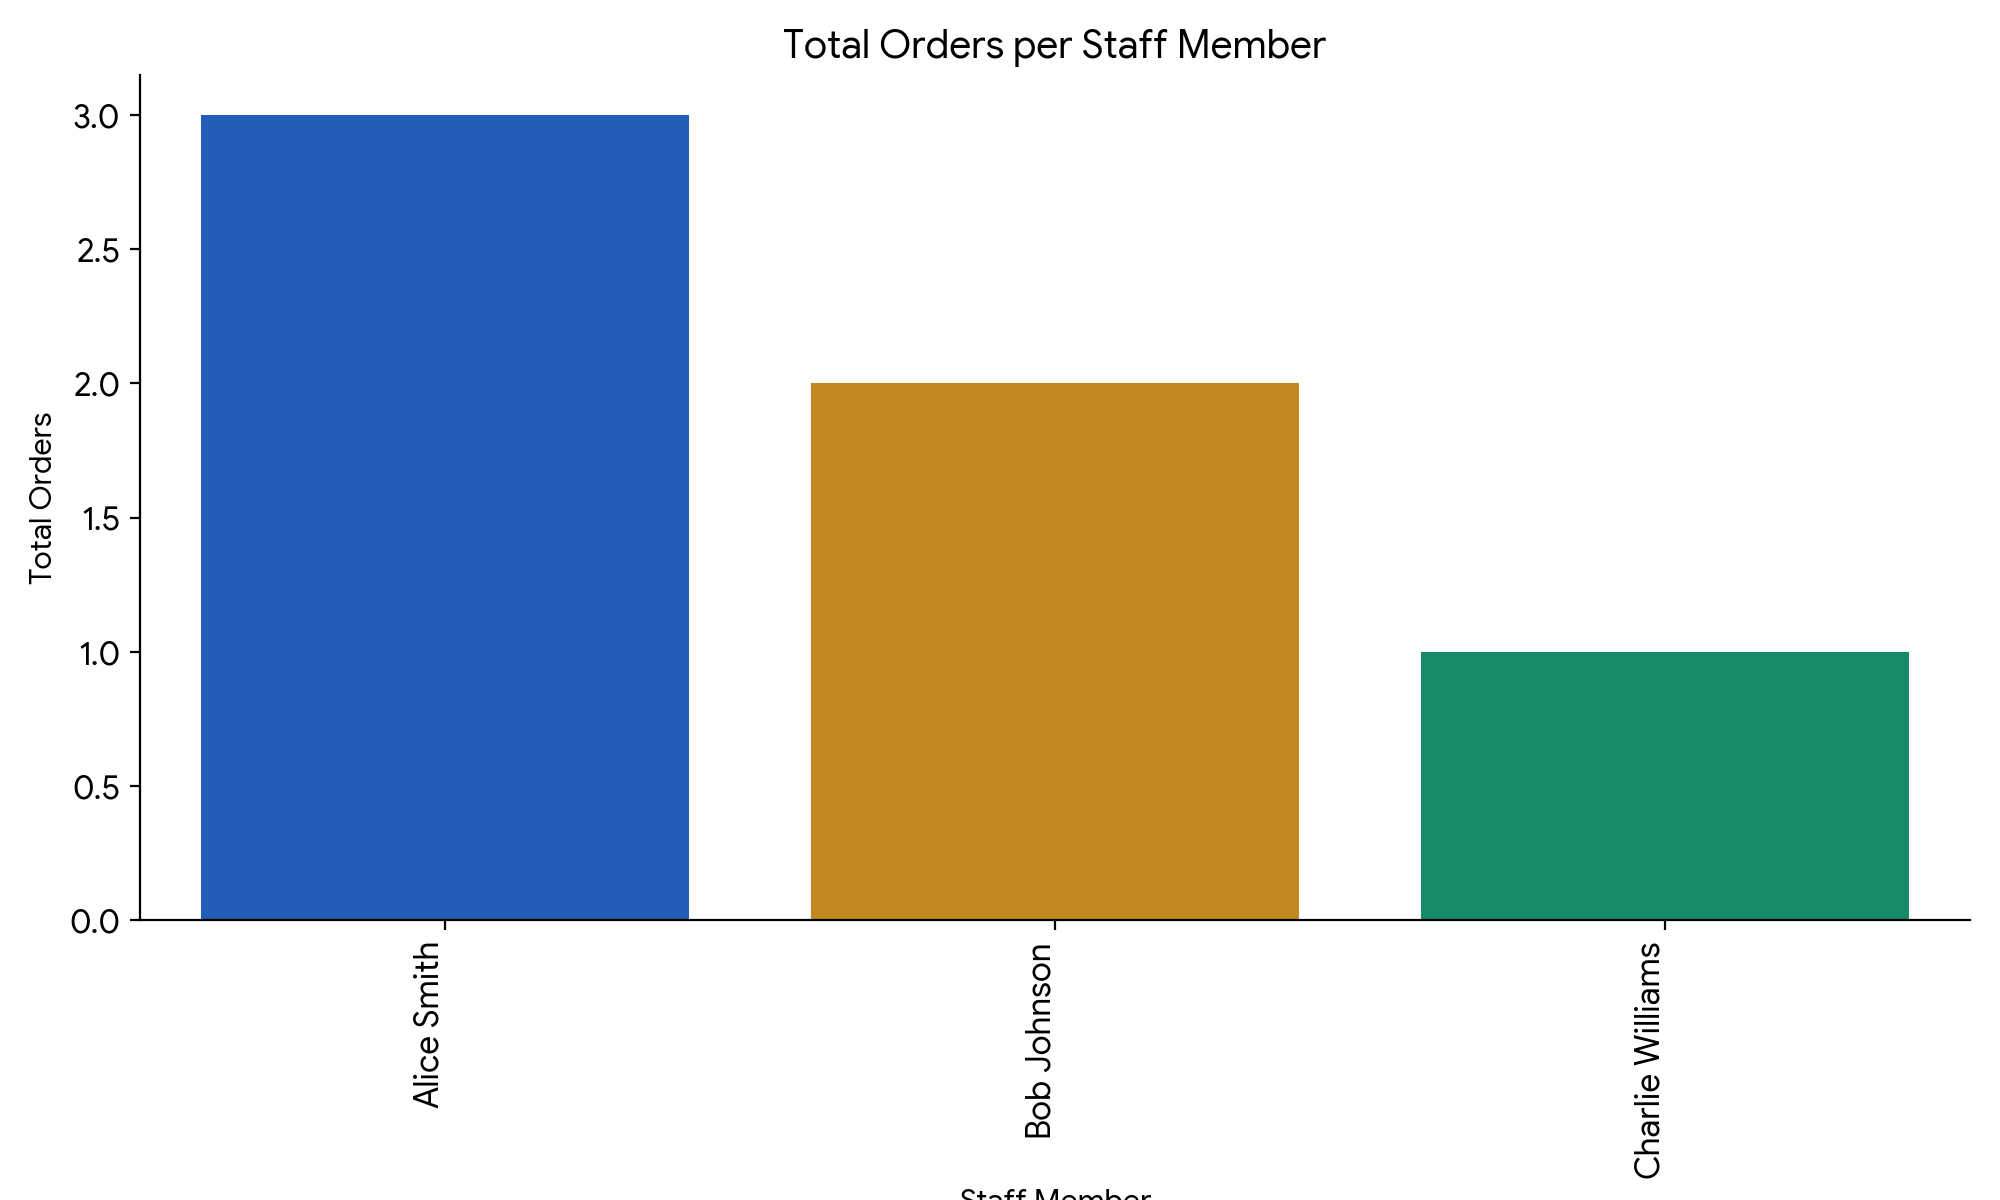

### Text

저는 그래프를 성공적으로 생성하고 플로팅했습니다. 여기에는 각 직원의 총 주문 수를 보여주는 막대 그래프가 표시됩니다.


In [16]:
async with live_client.aio.live.connect(model=model, config=config) as session:

    # message = "Can you figure out the number of orders that were made by each of the staff?"
    message = "각 직원이 주문한 수량을 알아낼 수 있나요?"

    await chat(session, message)

    # message = "Generate and run some code to plot this as a python seaborn chart using staff's name"
    message = "직원 이름을 사용하여 Python Seaborn 차트로 이를 간결하게 플로팅하기 위한 코드를 생성하고 실행합니다."

    await chat(session, message)
